# CNN + LSTM Pipeline for NSL-KDD Dataset

In [7]:
# Install and Import Required Libraries
# Ensure TensorFlow is installed in your environment: pip install tensorflow numpy pandas scikit-learn matplotlib seaborn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import shap


## Step 1: Data Loading

In [8]:
# Column names for NSL-KDD dataset
c_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

# Load training and testing datasets
train = pd.read_csv("data/KDDTrain+.txt", names=c_names)
test = pd.read_csv("data/KDDTest+.txt", names=c_names)

## Step 2: Data Preprocessing

In [9]:
# Drop 'difficulty_degree' column as it does not add value
del train["difficulty_degree"]
del test["difficulty_degree"]

# Convert categorical features to numerical
categorical_features = ["protocol_type", "service", "flag"]

for col in categorical_features:
    train[col] = train[col].astype("category").cat.codes
    test[col] = test[col].astype("category").cat.codes

# Map 'labels' column to binary classes (1 for 'normal', 0 for 'attack')
train["labels"] = train["labels"].apply(lambda x: 1 if x == "normal" else 0)
test["labels"] = test["labels"].apply(lambda x: 1 if x == "normal" else 0)

# Separate features and labels
X_train = train.drop("labels", axis=1)
y_train = train["labels"]
X_test = test.drop("labels", axis=1)
y_test = test["labels"]

# Normalize features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Step 3: Reshape Input for CNN + LSTM

In [10]:
# Add a temporal dimension (e.g., time_steps = 5)
time_steps = 5
x_train_reshaped = np.expand_dims(x_train, axis=1).repeat(time_steps, axis=1)
x_val_reshaped = np.expand_dims(x_val, axis=1).repeat(time_steps, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1).repeat(time_steps, axis=1)

## Step 4: Define the CNN + LSTM Model

In [11]:
model = keras.Sequential([
    layers.Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(time_steps, x_train.shape[1])),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 64)             7936      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            98816     
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                      

## Step 5: Train the Model

In [12]:
history = model.fit(
    x_train_reshaped, y_train,
    epochs=40,
    batch_size=64,
    validation_data=(x_val_reshaped, y_val)
)

Epoch 1/40
1575/1575 [==============================] - 15s 8ms/step - loss: 0.0607 - accuracy: 0.9792 - val_loss: 0.0289 - val_accuracy: 0.9897
Epoch 2/40
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0325 - accuracy: 0.9876 - val_loss: 0.0231 - val_accuracy: 0.9909
Epoch 3/40
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0284 - accuracy: 0.9894 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 4/40
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0273 - accuracy: 0.9897 - val_loss: 0.0207 - val_accuracy: 0.9930
Epoch 5/40
1575/1575 [==============================] - 14s 9ms/step - loss: 0.0249 - accuracy: 0.9912 - val_loss: 0.0190 - val_accuracy: 0.9932
Epoch 6/40
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0238 - accuracy: 0.9915 - val_loss: 0.0221 - val_accuracy: 0.9917
Epoch 7/40
1575/1575 [==============================] - 12s 8ms/step - loss: 0.0233 - accuracy: 0.9919 - val_loss: 0.0178 - val_ac

## Step 6: Evaluate the Model

In [13]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

705/705 [==============================] - 2s 3ms/step - loss: 1.3371 - accuracy: 0.7744
Test Loss: 1.3370552062988281, Test Accuracy: 0.7744410634040833


## Step 7: Visualizations

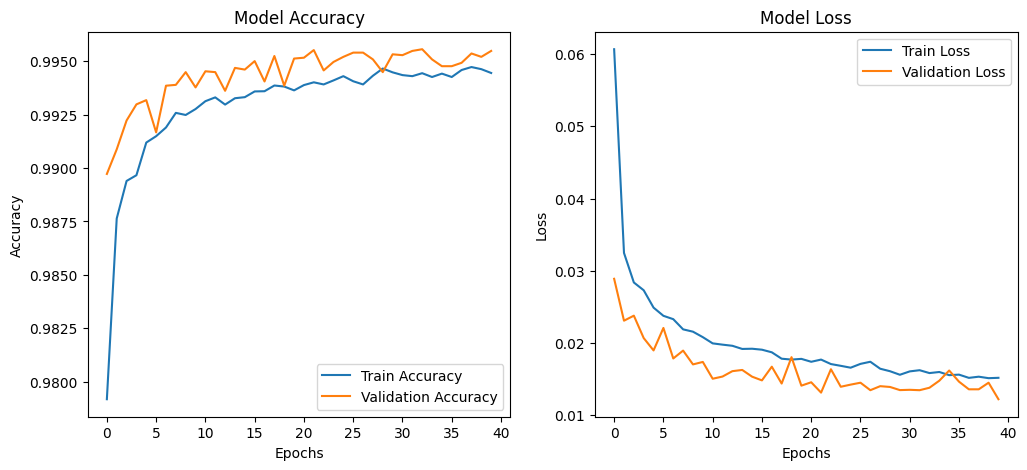

In [14]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

705/705 [==============================] - 2s 2ms/step


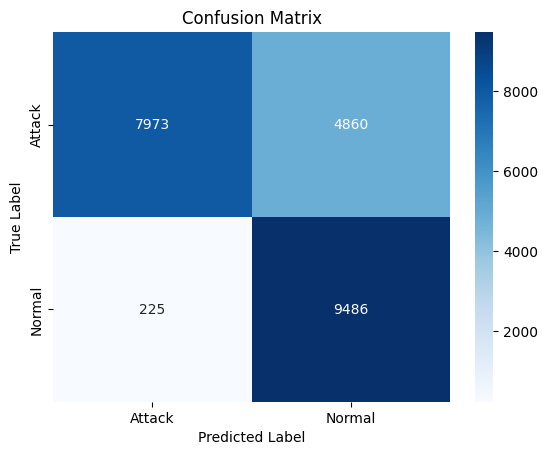

              precision    recall  f1-score   support

      Attack       0.97      0.62      0.76     12833
      Normal       0.66      0.98      0.79      9711

    accuracy                           0.77     22544
   macro avg       0.82      0.80      0.77     22544
weighted avg       0.84      0.77      0.77     22544



In [15]:
# Confusion Matrix
y_pred = (model.predict(X_test_reshaped) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Attack", "Normal"], yticklabels=["Attack", "Normal"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=["Attack", "Normal"]))

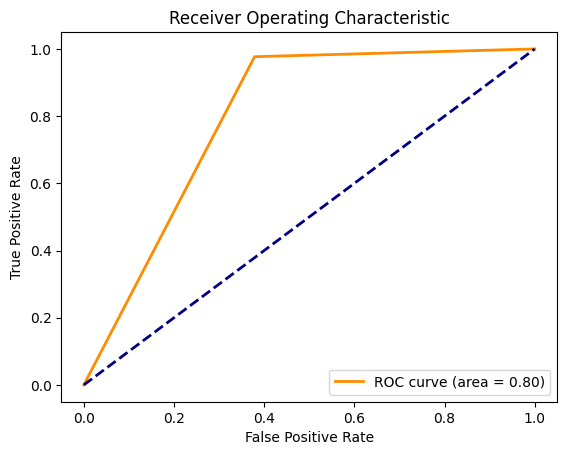

: 

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# SHAP Analysis with Partial Data
import shap

# Select a subset of the data for SHAP analysis
subset_size = 100  # Adjust the number of samples as needed
X_test_subset = X_test[:subset_size]
x_train_subset = x_train[:subset_size]

# Initialize the SHAP explainer using the subset of training data
explainer = shap.Explainer(model.predict, x_train_subset)

# Generate SHAP values for the test subset
shap_values = explainer(X_test_subset)

# Define feature names explicitly as a list
feature_names = list(train.columns[:-1])  # Convert to list for SHAP compatibility

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)
plt.savefig("visualization/shap_summary_plot.png")
plt.close()

# SHAP Decision Plot
shap.decision_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    feature_names=feature_names
)
plt.savefig("visualization/shap_decision_plot.png")
plt.close()

# SHAP Force Plot (Single Instance)
shap.force_plot(
    shap_values.base_values[0], 
    shap_values.values[0], 
    X_test_subset[0], 
    feature_names=feature_names, 
    matplotlib=True
)
shap.save_html(
    "visualization/shap_force_plot.html", 
    shap.force_plot(
        shap_values.base_values[0], 
        shap_values.values[0], 
        X_test_subset[0], 
        feature_names=feature_names
    )
)
